In [2]:
from functools import partial
import math

import jax
import jax.numpy as np
import flax.linen as nn
import optax
from flax.training import train_state
from typing import Any

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

## The dataset

We'll use two moons to keep things simple.

(-1.0, 1.0)

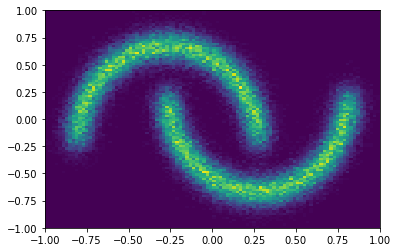

In [3]:
n_samples = 100000

x, _ = datasets.make_moons(n_samples=n_samples, noise=0.1)

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1),)
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-1 ,1)
plt.ylim(-1, 1)

In [4]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is used to define the consistency function.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x, t):
        
        t = get_timestep_embedding(t[..., 0])
        x = np.concatenate([x, t], -1)
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [ ]:
## Utility functions

def get_timestep_embedding(timesteps, embedding_dim: int = 8, dtype=np.float32):
    """Build sinusoidal embeddings (from Fairseq)."""

    assert len(timesteps.shape) == 1
    timesteps *= 1000

    half_dim = embedding_dim // 2
    emb = np.log(10_000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim, dtype=dtype) * -emb)
    emb = timesteps.astype(dtype)[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # Zero pad
        emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

def karras_boundaries(sigma, eps, N, T):
    """Boundaries for the time discretization."""
    idx = np.arange(N)
    return (eps ** (1 / sigma) + idx / (N - 1) * (T ** (1 / sigma) - eps ** (1 / sigma))) ** sigma

def apply_ema_decay(state, ema_decay):
    """Apply exponential moving average (EMA) decay to the model parameters and return the updated state."""
    params_ema = jax.tree_map(lambda p_ema, p: p_ema * ema_decay + p * (1. - ema_decay), state.params_ema, state.params)
    state = state.replace(params_ema = params_ema)
    return state

In [5]:
def f_theta(params, score, x, t):
    """ Consistency function
    """
    
    sigma_data = 0.5
    
    c_skip = sigma_data ** 2 / ((t - eps) ** 2 + sigma_data ** 2)
    c_out = sigma_data * (t - eps) / np.sqrt(sigma_data ** 2 + t ** 2)
    
    x_out = score.apply(params, x, t)
    
    return x * c_skip + x_out * c_out

In [6]:
@partial(jax.jit, static_argnums=(5,))
def loss_fn(params, params_ema, x, t1, t2, score, key):
    """ Discrete-steps loss function
    """
    z = jax.random.normal(key, shape=x.shape)

    x2 = x + z * t2
    x2 = f_theta(params, score, x2, t2)
    
    x1 = x + z * t1
    x1 = f_theta(params_ema, score, x1, t1)
    
    return np.mean((x1 - x2) ** 2) 

In [8]:
key = jax.random.PRNGKey(42)

score = MLP(hidden_dim=128, out_dim=2, n_layers=6)
t = np.ones((x.shape[0], 1))
params = score.init(key, x, t)

In [9]:
# Prepare train state

class TrainState(train_state.TrainState):
    params_ema: Any = None
    
tx = optax.adam(learning_rate=1e-3)

state = TrainState.create(
              apply_fn=score.apply, 
              params=params, 
              tx=tx, 
              params_ema=params)

In [12]:
num_steps = 70000
num_batch = 128    
    
s0 = 2
s1 = 150
mu0 = 0.9
T = 60.
eps = 0.002

with trange(num_steps) as steps:
    for step in steps:

        N = math.ceil(math.sqrt((step * ((s1 + 1) ** 2 - s0 ** 2) / num_steps) + s0 ** 2) - 1) + 1
        mu = math.exp(s0 * math.log(mu0) / N)
        
        boundaries = karras_boundaries(7.0, eps, N, T)

        # Draw a random batches from x
        key, _ = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(num_batch,))

        x_batch = x[idx]
        key, _ = jax.random.split(key)
        n_batch = jax.random.randint(key, minval=0, maxval=N, shape=(x_batch.shape[0], 1))
        
        key, _ = jax.random.split(key)
        loss, grads = jax.value_and_grad(loss_fn)(state.params, state.params_ema, x_batch, boundaries[n_batch], boundaries[n_batch + 1], score, key)            
        state = state.apply_gradients(grads=grads)
        state = jax.lax.stop_gradient(apply_ema_decay(state, mu))
        
        steps.set_postfix(val=loss)

In [ ]:
def sample(params, score, ts, key):
    """ Sample from consistency model
    """
    
    x0 = jax.random.normal(key, shape=(n_samples, 2)) * ts[0]
    x = f_theta(params, score, x0, np.repeat(ts[0], x0.shape[0])[:, None])
        
    for t in ts[1:]:
        key, _ = jax.random.split(key)
        z = jax.random.normal(key, shape=x0.shape)
        x = x + math.sqrt(t ** 2 - eps ** 2) * z
        x = f_theta(params, score, x, np.repeat(t, x0.shape[0])[:, None])
        
    return x

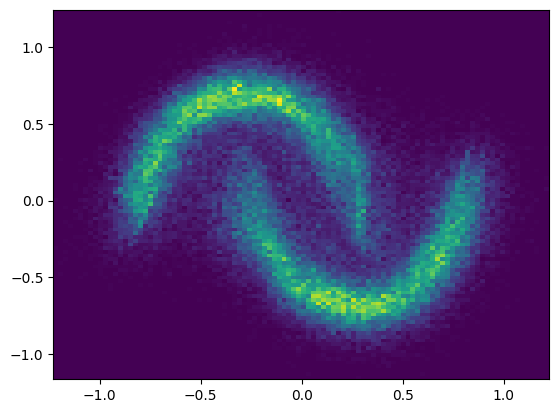

In [225]:
# Five-step generation

n_samples = 100000
x_samples = sample(state.params, score, list(reversed([0.1, 2., T / 4., T / 2., T])), key)
plt.hist2d(x_samples[:, 0], x_samples[:, 1], bins=100);

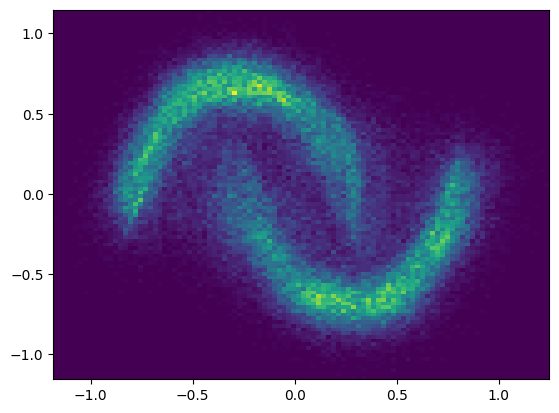

In [232]:
# Two-step generation

n_samples = 100000
x_samples = sample(state.params, score, list(reversed([0.1, T])), key)
plt.hist2d(x_samples[:, 0], x_samples[:, 1], bins=100);